# VERIFICATION AND VALIDATION: STATIC TESTING

This notebook addresses testing kinetics models. We begin with a motivating example, and then the next two sections provide details of verification testing.
The final section applies these techniques to the running example of glycolytic oscillations.

# Preliminaries

In [1]:
# Python packages used in this section
!pip install -q SBMLLint
!pip install -q tellurium
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request # use this library to download file from GitHub
from scipy import fftpack
from SBMLLint.tools.sbmllint import lint
import tellurium as te

## Models

In [3]:
LINEARY_PATHWAY_MODEL = """
R1:  S1 -> S2; k1*S1  
R2: S2 -> S3; k2*S2
R3: S3 -> S4; k3*S3
R4: S4 -> S5; k4*S4

S1 = 10

// Parameters
k1 = 0; # Nominal value of parameter
k2 = 0; # Nominal value of parameter
k3 = 0; # Nominal value of parameter
k4 = 0; # Nominal value of parameter
"""

In [4]:
WOLF_MODEL = """
// Created by libAntimony v2.12.0.3
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;
  
  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k;
  const J4_kg, J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2;
  const J9_k, J10_k;
end

"""

## Helper Functions

In [5]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index("time")
    return df

# Tests
rr = te.loada(WOLF_MODEL)
data = rr.simulate()
assert(isinstance(arrToDF(data), pd.DataFrame))
print("OK!")

OK!


In [8]:
def generateNoisyData(model, std, parameter_dct=None):
    """
    Generates noise columns in a dataframe.
    
    Parameters
    ----------
    model: str (Antimony model)
    std: float (standard deviation of generated noise)
    parameter_dct: dict (parameters to change)
    
    Returns
    ------
    SBstoat.NamedTimeseries
    """
    if parameter_dct is None:
        parameter_dct = {}
        #
    rr = te.loada(model)
    for key, value in parameter_dct.items():
        rr[key] = value
    df = arrToDF(rr.simulate())
    ser = df.mean()
    # Use the input DataFrame as a template
    noise_df = df.copy()
    # Create the noise data
    for column in noise_df.columns:
        noise_arr = np.random.normal(0, 0.2, len(noise_df))
        noise_df[column] = ser.loc[column]*noise_arr 
    return noise_df + df

# Tests
df = generateNoisyData(WOLF_MODEL, 0, parameter_dct={"J1_k1": 3})
assert(isinstance(df, pd.DataFrame))
assert(len(df) > 0)
print("OK!")

OK!


# Mass Balance Errors

This is a more refined analysis of resolving a mass balance error.
Consider the following simulation of ``ATP`` hydrolysis and ``ADP`` phosphorylation.
We use the equilibrium constant (``Keq``) of 1.
This is not a physiological value for ``Keq``, but useful for our example.

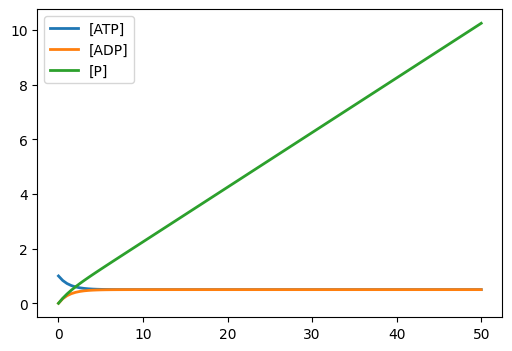

In [9]:
ATP1_MODEL = """
J0: ATP -> ADP + P; k_f*ATP  
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP1_MODEL)
rr.plot(rr.simulate(0, 50, 100))

Our expectation is that at equilibrium, ``ATP = ADP`` by definition of the equilibrium constant.
Instead, ``P`` increases without bound,
and ``ATP = 0 = ADP``.

As we saw in the slides,
the underlying issue is that inorganic phosphate (``P``)
is treated inconsistently:
``P`` appears as a product of hydrolysis,
but ``P`` is not present in ``ATP`` synthesis.

We have a couple of choices for resolving this error.
Below, we revise the model to include ``P`` in
the synthesis reaction.
The revised reaction is ``J1a``.

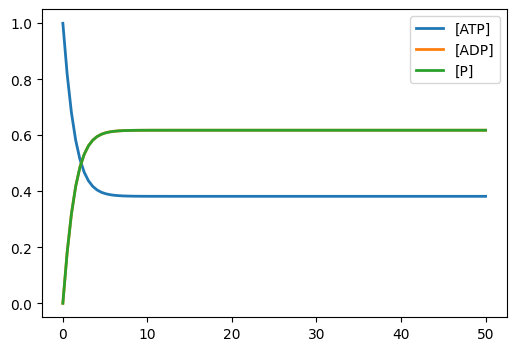

In [10]:
ATP2_MODEL = """
J0: ATP -> ADP + P; k_f*ATP  
J1a: ADP + P -> ATP; k_r*ADP*P

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP2_MODEL)
rr.plot(rr.simulate(0, 50, 100))

Now, we get a more reasonable result. (Note that the line for ``ADP`` and ``P`` are coincident.) The concentrations of ``ATP`` and ``ADP`` differ because $K_{eq} = \frac{[ATP]}{[ADP] [P]} = \frac{0.64}{(0.4)(0.4)}$.

There is another way of fixing the mass balance error that reqults in ``ATP = ADP``. This solution assumes that there is a
large concentration of ``P`` that is relatively unchanged as a result of the hydolysis and phosphorylation reactions.
So, ``P`` does not appear in the model.

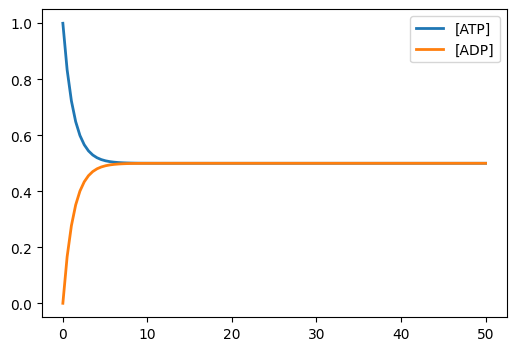

In [11]:
ATP3_MODEL = """
J0a: ATP -> ADP; k_f*ATP 
J1: ADP -> ATP; k_r*ADP

Keq = 1
k_f = 0.4
k_r = k_f/Keq
ATP = 1
ADP = 10e-5
"""

rr = te.loada(ATP3_MODEL)
rr.plot(rr.simulate(0, 50, 100))

# Detecting Mass Balance Errors

Having seen the dramatic impact of undetected mass balance errors, it is natural to ask how they can be detected. There are two general approaches.
The first requires knowing the chemical composition of each chemical species.
For example, [atomic mass analysis](https://www.nature.com/articles/s41587-020-0446-y) counts the atoms of each type in the reactants and compares each count with the corresponding counts of atoms in the products.
This approach has two challenges.
First, the modeler must use annotations or other means to expose the chemical structure of species; this is not always available (especially
for larger molecules that can be in many different chemical states of phosphorylation, methylation, etc.).
A second problem is that it forces the modeler to write unnecessarly detailed reactions.
For example, ``ATP2_MODEL`` fails this kind of mass balance checking because there is no accounting for the $\gamma$ phosphate of ``ATP``.

An alternative approach is to check for a condition that is a bit weaker than mass balance.
Referred to as **stoichiometric inconsistency**, such inconsistencies are detected if there is no assignment of masses to
the chemical species such that the reaction network (without boundary reactions) neither creates nor destroys chemical species.

The technical details of this latter approach are described in this [article](https://academic.oup.com/bioinformatics/article/37/3/388/5892254).
The paper introduces the GAMES algorithm that uses graphical techniques to analyze mass equivalences implied by the reaction network.
For example, reaction ``J0`` implies that the mass of ``ATP`` is equal to the sum of the masses of ``ADP`` and ``P``.

GAMES is in the SBMLLint ``pip`` installable package. It can be run at the command line
via ``games <SBML file>``. It can also be run programmatically, such as within a Jupyter notebook.
Below, we show how to apply the GAMES to the above examples.


In [12]:
_ = lint(ATP1_MODEL, mass_balance_check="games")

Model analyzed...
At least one error found.


ADP = ATP by reaction(s):
1. J1: ADP -> ATP

However, ADP < ATP by reaction(s):
2. J0: ATP -> ADP + P


----------------------------------------------------------------------



**********************************************************************




GAMES detected that the first model is stoichiometric inconsisent. Further, GAMES provides a simple argument for how this detection is made.
Statement (1) explains that GAMES inferred that the mass of ``ADP`` is equal to the mass of ``ATP``.
However, this is contradicted by a second finding that the mass of ``ADP`` is less than the mass of ``ATP``.

In [13]:
_ = lint(ATP2_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


In [14]:
_ = lint(ATP3_MODEL, mass_balance_check="games")

Model analyzed...
No error found.


# Other Errors Detectable By Static Analysis

There are other errors in reaction networks that can be detected statically. Systems such as MEMOTE detect the following errors:
- *Blocked reactions* are reactions where one or more reactant is never present and so the reaction never ocurs.
- *Dead end metabolite* are chemical species that are produced but not consumed.
- *Orphan metabolites* are chemical species that are consumed but not produced.
- *Charge imbalance* reactions are reactions that do not preserve the charge of the reactants in the products.

The foregoing errors apply to the mass transfer part of reactions. Of course, errors are also possible in the kinetics laws.
Among these errors are:
- *Incorrect reference to chemical species*. To illustrate, consider a reaction in which the modeler intended to use mass action kinetcs, but
wrote the reaction as ``A -> B; k * B``.
- *Errors in the function used in the kinetics law*. A common example here is to inadevertently use zeroth order kinetics for
the degradation of a chemical species.
For example, ``B ->; k``. The problem is that this can result in ``B`` becoming negative since its value is reduced
regardless of whether ``B`` is present. Clearly, we cannot have a negative concentration.

# Simple Exercise

In [15]:
modelStr = """

v8: c10 + c10 -> c11; 1
v13: c10 + c154 -> c160; 1
v208: c6 + c16 -> c10; 1
v523: c6-> c86; 1
v537: c160 -> c86; 1
v601: c154 -> c86;1
"""

rr = te.loada(modelStr)

In [16]:
# Look for Stoichiometric Inconsistencies in BioModels model
_ = lint(modelStr, mass_balance_check="games")

Model analyzed...
At least one error found.


c154 = c86 by reaction(s):
1. v601: c154 -> c86

c86 = c160 by reaction(s):
2. v537: c160 -> c86

However, c154 < c160 by reaction(s):
3. v13: c10 + c154 -> c160


----------------------------------------------------------------------



**********************************************************************


We detected a mass imbalance from the following reactions:

These uni-uni reactions created mass-equivalence.

1. v523: c6 -> c86
2. v601: c154 -> c86
3. v537: c160 -> c86

----------------------------------------------------------------------

The following reactions create mass-inequality.

4. v208: c6 + c16 -> c10
5. v13: c10 + c154 -> c160

----------------------------------------------------------------------

Based on the reactions above, we have mass-equivalent pseudo reactions.

(pseudo 4.) v208: {c16} + {c154=c160=c6=c86} -> {c10}
(pseudo 5.) v13: {c154=c160=c6=c86} + {c10} -> {c154=c160=c6=c86}

------------------------------

# Longer Exercise

## Checking the Wolf Model

In [17]:
print(WOLF_MODEL)


// Created by libAntimony v2.12.0.3
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glycerald

1. Use SBMLLint to find mass check for mass balance errors in the Wolf model in ``WOLF_MODEL``.

1. Reaction ``J9`` implies that ``ATP`` and ``ADP`` have the same mass, which is clearly false since they differ
by an inorganic phosphate.
Revise the Wolf model to explicitly include
inorganic phosphate and check your revised model
with SBMLLint.
Do you get the same dynamics with the revised model
as with the original Wolf model?

## Limitations of Stoichiometric Inconsistency

We will modify the Wolf Model to explore mass balance errors that SI can catch.
1. Add a new reaction: $P \rightarrow 2 P$. Does ``lint`` report an error?
1. Modify reaction ``J9`` to include an explicity phosphate, but do not do this elsewhere in the model. Does ``lint`` detect an inconsistency?
1. Delete Glucose as a reactant in J1 and lint the model. Is an error detected?
1. What insights do you have about when SI does and does not detect a mass balance error?

In [18]:
newWolfModel = """
  model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;
  
  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k;
  const J4_kg, J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2;
  const J9_k, J10_k;
end
"""
model = te.loada(newWolfModel)